In [1]:
import numpy as np
import pandas as pd
import joblib
import random

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [2]:
#-------------
#load dataset
#-------------
df = pd.read_csv("yield_df.csv")
df.head()

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [3]:
#--------------
# Drop unnecessary index column if present
#-----------------
drop_cols = [c for c in df.columns if c.lower().startswith("unnamed")]
df = df.drop(columns=drop_cols, errors="ignore")

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (28242, 7)


,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37


In [4]:
# -------------------
# Features & target
# -------------------
X = df.drop(columns=["hg/ha_yield"])
y = df["hg/ha_yield"]

# optional log-transform for stability
y_log = np.log1p(y)

# Identify categorical & numeric columns
cat_cols = ["Area", "Item"]
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categorical cols:", cat_cols)
print("Numeric cols:", num_cols)

Categorical cols: ['Area', 'Item']
Numeric cols: ['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']


In [5]:
# -------------------
# Preprocessing
# -------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False, min_frequency=10)),
        ]), cat_cols),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), num_cols),
    ],
    remainder="drop"
)

In [6]:
# -------------------
# Train/Test Split
# -------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

In [7]:
# -------------------
# Candidate Models
# -------------------
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "HistGB": HistGradientBoostingRegressor(random_state=42),
    "GradientBoost": GradientBoostingRegressor(random_state=42),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
}

param_distributions = {
    "RandomForest": {
        "model__n_estimators": [100, 200, 400],
        "model__max_depth": [10, 20, None],
        "model__min_samples_split": [2, 5, 10],
    },
    "HistGB": {
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [6, 10, None],
        "model__max_iter": [200, 400],
    },
    "GradientBoost": {
        "model__n_estimators": [100, 200, 400],
        "model__learning_rate": [0.01, 0.05, 0.1],
        "model__max_depth": [3, 5, 8],
    },
    "Ridge": {
        "model__alpha": np.logspace(-3, 3, 10)  
    }, 
    "Lasso": {
        "model__alpha": np.logspace(-4, 2, 15)   
    },
    "ElasticNet": {
        "model__alpha": np.logspace(-4, 2, 10),
        "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9] 
    }
}

In [8]:
# -------------------
# Train & Evaluate
# -------------------
best_models = {}
results = []

for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_distributions.get(name, {}),
        n_iter=5, cv=3,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        random_state=42
    )
    
    search.fit(X_train, y_train)
    
    best_models[name] = search.best_estimator_
    
    # Evaluate
    y_pred = search.best_estimator_.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    r2 = r2_score(y_test, y_pred)
    
    print(f"✅ {name}: RMSE={rmse:.4f}, R²={r2:.4f}")
    results.append((name, rmse, r2))


🔹 Training RandomForest...
✅ RandomForest: RMSE=0.1439, R²=0.9831

🔹 Training HistGB...
✅ HistGB: RMSE=0.2832, R²=0.9345

🔹 Training GradientBoost...
✅ GradientBoost: RMSE=0.2849, R²=0.9337

🔹 Training Ridge...
✅ Ridge: RMSE=0.4500, R²=0.8347

🔹 Training Lasso...
✅ Lasso: RMSE=0.4505, R²=0.8344

🔹 Training ElasticNet...
✅ ElasticNet: RMSE=0.4890, R²=0.8048


In [9]:
# -------------------
# Pick Best Model
# -------------------
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R2"]).sort_values("RMSE")
print("\n📊 Results:")
print(results_df)

best_name = results_df.iloc[0]["Model"]
best_model = best_models[best_name]

print(f"\n🏆 Best Model: {best_name}")
joblib.dump(best_model, f"best_model_{best_name}.joblib")


📊 Results:
           Model      RMSE        R2
0   RandomForest  0.143887  0.983103
1         HistGB  0.283213  0.934536
2  GradientBoost  0.284909  0.933749
3          Ridge  0.450038  0.834699
4          Lasso  0.450484  0.834371
5     ElasticNet  0.488995  0.804842

🏆 Best Model: RandomForest


['best_model_RandomForest.joblib']

In [10]:
#--------
# Make predictions on a few samples
#--------
print("Sample predictions vs actual values:")
for i in range(5):
    print(f"Predicted: {y_pred[i]:.2f}, Actual: {y_test.iloc[i]:.2f}")


Sample predictions vs actual values:
Predicted: 11.11, Actual: 11.15
Predicted: 9.63, Actual: 9.90
Predicted: 10.22, Actual: 10.84
Predicted: 12.07, Actual: 12.03
Predicted: 11.12, Actual: 10.94


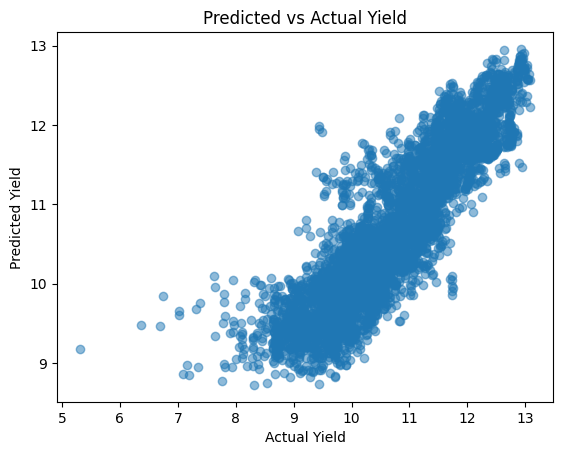

In [11]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs Actual Yield")
plt.show()


In [12]:
#-----------------
# Example new input
#-----------------
new_data = pd.DataFrame([{
    "Area": "India",
    "Item": "Maize",
    "Year": 2020,
    "average_rain_fall_mm_per_year": 1200,
    "pesticides_tonnes": 500,
    "avg_temp": 25
}])


In [13]:
predicted_yield = search.best_estimator_.predict(new_data)
print("Predicted Yield:", predicted_yield[0])


Predicted Yield: 10.381391870477872
